In [7]:
#import relative packages
import numpy as np
from gensim import corpora, models, similarities
from cheaters import dctConstr
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
# loading frankenstein.txt text
with open('frankenstein.txt', 'r', encoding='utf-8') as f:
    corp = f.read()

dct = dctConstr(stop_words=["i", "you", "a"], ignore_case=True)
dct.constructor(corp)

# split paragraphs
def split_by_paragraphs(data:str) -> []:
    processed=data.lower()
    while '\n\n\n' in processed:
        processed=processed.replace('\n\n\n','\n\n')
    out = processed.split('\n\n')
    return [o.replace("\n", " ") for o in out]
# save the splited text into the list pcorp
pcorp = split_by_paragraphs(corp)
# convort original txt data to sparse vectors of Bag-of-words model 
# ex. [[(10,2)]] represents a word showed once in dictinary to index of 13
pbow = [dct(para) for para in pcorp]
# count frequency of words and flip dictionary for reversal
# ex. [(14, 1.923076923076923e-05), (28, 1.923076923076923e-05)]
ptfidf = [dct.tfidf(para) for para in pcorp]
pvec = [dct.bow_to_vec(p) for p in pbow]
idx_to_terms = {i:j for j, i in dct.terms.items()} # flip dictionary for reversal
print(f"The corpus consists of {len(pvec[0])} terms and {len(pcorp)} documents")

The corpus consists of 7373 terms and 790 documents


In [9]:
# data processing
# set stopwords
stoplist = set('for a of the and to in'.split())
# fliter for stopwords
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in pcorp
]
# use gensim.corpora.dictionary,.Dictionary class to assign unique integer ID number 
# for every word in the dictionary
# This step gathered the number of words and other relative information
dictionary = corpora.Dictionary(texts)
# dictionary.doc2bow(text)is to convert text to sparse vectors，[(0, 2), (1, 1)]，for example，present the words of ID 0,1
# appears twice and once, respectively, and other words do not appear.
corpus = [dictionary.doc2bow(text) for text in texts]

2023-01-27 14:18:05,029 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-01-27 14:18:05,085 : INFO : built Dictionary(11212 unique tokens: ['1', 'letter', '_to', 'england._', 'mrs.']...) from 790 documents (total 60190 corpus positions)
2023-01-27 14:18:05,086 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(11212 unique tokens: ['1', 'letter', '_to', 'england._', 'mrs.']...) from 790 documents (total 60190 corpus positions)", 'datetime': '2023-01-27T14:18:05.086601', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [10]:
# construct LDA num_topics为10
lda = models.ldamodel.LdaModel(corpus=pbow, id2word=idx_to_terms, num_topics=10)

2023-01-27 14:18:06,671 : INFO : using symmetric alpha at 0.1
2023-01-27 14:18:06,678 : INFO : using symmetric eta at 0.1
2023-01-27 14:18:06,682 : INFO : using serial LDA version on this node
2023-01-27 14:18:06,690 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 790 documents, updating model once every 790 documents, evaluating perplexity every 790 documents, iterating 50x with a convergence threshold of 0.001000
2023-01-27 14:18:06,691 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-27 14:18:07,146 : INFO : -10.685 per-word bound, 1646.7 perplexity estimate based on a held-out corpus of 790 documents with 70619 words
2023-01-27 14:18:07,147 : INFO : PROGRESS: pass 0, at document #790/790
2023-01-27 14:18:07,474 : INFO : topic #3 (0.100): 0.050*"the" + 0.033*"to" + 0.029*"of" + 0.023*"and" + 0.016*"my" + 0.015*"was" + 0.014*"in" + 0.012*"me"

In [11]:
# split 80% training and 20% test sets
import random
random.seed(11) #set random seed
# shuffle corpus
cp = list(corpus)
random.shuffle(cp)

# split into 80% training and 20% test sets
p = int(len(cp) * .8)
cp_train = pbow[0:p]
cp_test = pbow[p:]
lda = models.ldamodel.LdaModel(corpus=cp_train, id2word=idx_to_terms, num_topics=10)

2023-01-27 14:18:08,528 : INFO : using symmetric alpha at 0.1
2023-01-27 14:18:08,530 : INFO : using symmetric eta at 0.1
2023-01-27 14:18:08,533 : INFO : using serial LDA version on this node
2023-01-27 14:18:08,541 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 632 documents, updating model once every 632 documents, evaluating perplexity every 632 documents, iterating 50x with a convergence threshold of 0.001000
2023-01-27 14:18:08,542 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-27 14:18:08,914 : INFO : -10.982 per-word bound, 2022.3 perplexity estimate based on a held-out corpus of 632 documents with 56872 words
2023-01-27 14:18:08,915 : INFO : PROGRESS: pass 0, at document #632/632
2023-01-27 14:18:09,189 : INFO : topic #6 (0.100): 0.033*"and" + 0.029*"the" + 0.023*"of" + 0.021*"my" + 0.015*"to" + 0.014*"me" + 0.010*"had" + 0.009*"in"

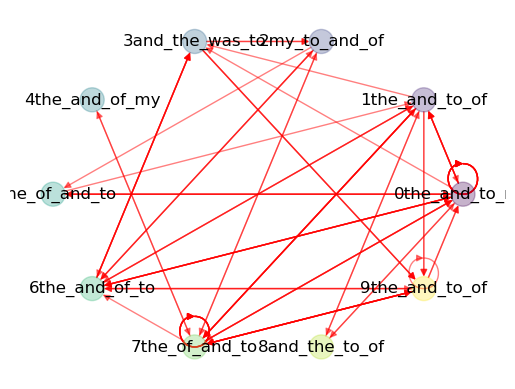

In [6]:
# https://networkx.org/documentation/latest/tutorial.html
# networkx as a net to show relaitions within  
import networkx as nx
from matplotlib import cm
import matplotlib.pyplot as plt

limit = 500  # number of paragraphs

def get_most_likely_topic(bow):
    # get distribution for topics of the text
    mm = lda.get_document_topics(bow)
    # sorting the distribution，ascending
    s = sorted(mm, key=lambda x: x[1])
    if s:
        return s[0][0]
    else:
        return 0

topic_labels = []
# construct topic lables
for num in range(lda.num_topics):
    lab = lda.show_topic(num)
    topic_labels.append(str(num) + "_".join([i[0] for i in lab[:4]]))

# set the format for graphs
viridis = cm.get_cmap('viridis', lda.num_topics)
newcolors = viridis(np.linspace(0, 1, lda.num_topics))

#get labels for the topic sequence
topic_sequence = [get_most_likely_topic(i) for i in pbow[:limit]]
labels = {num: i for num, i in enumerate(topic_labels)}

# construct list for nodes，and list for edges 
node_list = list(range(lda.num_topics))
nodecolor = newcolors
edge_list = []
for i in range(len(pbow[limit]) - 1):
    edge_list.append(
        (topic_sequence[i], topic_sequence[i + 1])
    )

# constrcut directed graph
G = nx.DiGraph()

# add nodes according to the number of num_topic
for i in range(lda.num_topics):
    G.add_node(i)

# construct edges
for i in edge_list:
    G.add_edge(i[0], i[1])

#  use Fruchterman-Reingold arithmetic to sort the lists
pos = nx.circular_layout(G)

# draw nodes
nx.draw_networkx_nodes(G,
                    pos,
                    nodelist=node_list,
                    node_color=nodecolor,
                    alpha=0.3)

# draw edges
nx.draw_networkx_edges(G, pos,
                       edgelist=edge_list,
                       width=1, alpha=0.5, edge_color='r')
# draw network
nx.draw_networkx_labels(G, pos,
                        labels=labels, font_size=12)

plt.rcParams['figure.figsize'] = [15, 10]
plt.axis('off')
plt.show()